In [1]:
%config Completer.use_jedi = False

In [2]:
import numpy as np
from netCDF4 import Dataset
import matplotlib.pyplot as plt
import tqdm
import pickle
import datetime
import pandas as pd

# Get AO Index

In [3]:
ao_dat = pd.read_csv('ao_index.csv')

ao_dat['year'] = [int(str(d)[:4]) for d in ao_dat['Date']]
ao_dat['month'] = [str(d)[-2:] for d in ao_dat['Date']]

ao_dat

,Date,Value,year,month
0,195001,-0.060,1950,01
1,195002,0.627,1950,02
2,195003,-0.008,1950,03
3,195004,0.555,1950,04
4,195005,0.072,1950,05
...,...,...,...,...
848,202009,0.631,2020,09
849,202010,-0.072,2020,10
850,202011,2.086,2020,11
851,202012,-1.736,2020,12


Text(0, 0.5, 'Arctic Oscillation Index')

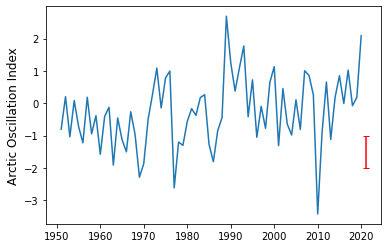

In [4]:
ao_chop = ao_dat.iloc[3:-2]
aod = list(ao_chop[ao_chop['month']=='12']['Value'])
aoj = list(ao_chop[ao_chop['month']=='01']['Value'])
aof = list(ao_chop[ao_chop['month']=='02']['Value'])

years = list(ao_chop[ao_chop['month']=='01']['year'])

djf_index = [np.nanmean([d,j,f]) for (d,j,f) in zip(aod,aoj,aof)]

plt.plot(years,djf_index)

plt.errorbar(2021,-1.5,yerr=0.5,color='r',capsize=3)

plt.ylabel('Arctic Oscillation Index',fontsize='large')

# Get ERA5 Data

In [41]:
with Dataset('/media/robbie/Brokendrive/E5/ERA_nh_1973_12.nc') as ERA5_data:
    lons = np.array(ERA5_data['longitude'])
    lats = np.array(ERA5_data['latitude'])
    
ERA5_lon_grid = np.array([np.array(lons), ] * 121)

ERA5_lat_grid = np.array([np.array(lats), ] * 1440).T

area_weighting = np.cos(np.radians(ERA5_lat_grid))

mon_weight = np.swapaxes(np.repeat(area_weighting[:,:,np.newaxis],31*8,axis=2).T,1,2)

In [23]:

print(np.isnan(np.array(d['vort_ave'])).any())

True


# Make vorticity index

False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
[-0.09529578, 0.3840361, 0.27908346, 0.047398496, 0.51142055, 0.37806237, -0.07205817, -0.12039506, 0.117118634, 1.0858904, 0.66113657, -0.4751102, 0.5458709, -0.035860345, 0.060202822, 0.76067144, 0.69727826, 0.33202076, 0.5868242, 1.1937187, 0.8619762, 0.90512824, -0.36451045, -0.50270903, 0.22913295, 0.14858392, 0.8070682, 0.10033732, 0.75528616, 0.26933444, -0.0035431408, 0.46813905, -0.37162176, 0.58501136, 0.16835745, -0.3428654, -0.96476936, -0.1527897, 0.050783116, 0.63544255, 0.07014036, 1.0467376, -0.17953596, 0.106686264, 0.65710574, 0.541814, 1.1431792]


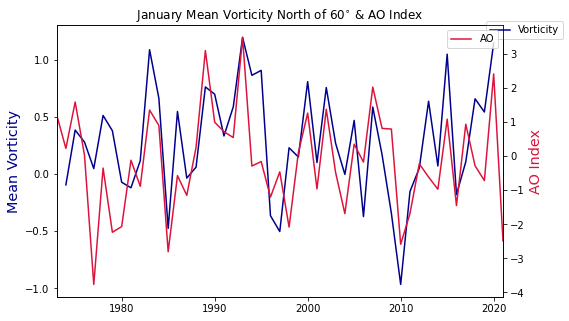

In [38]:
month = 1

years = np.arange(1974,2021)

mean_vorts = []

for year in years:

    d = Dataset(f'/home/robbie/Dropbox/beaufort_sea/vorticity_files/{year}{str(month).zfill(2)}.nc')

    mean_vort = np.average(np.array(d['vort_ave'][1:]), weights=area_weighting[1:])    

    mean_vorts.append(mean_vort)
    
print(mean_vorts)
    
ao_month = ao_dat[ao_dat['month']=='01']

fig, ax = plt.subplots(1,1,figsize=(8,5))

ax.plot(years,mean_vorts,color='darkblue',label='Vorticity')
ax.set_ylabel('Mean Vorticity', fontsize='x-large',color='darkblue')

ax2 = ax.twinx()
ax2.plot(ao_month['year'],ao_month['Value'],color='crimson',label='AO')

ax.set_xlim(1973,2021)

ax2.set_ylabel('AO Index', fontsize='x-large',color='crimson')

ax.set_title(r'January Mean Vorticity North of 60$^{\circ}$ & AO Index')

ax.legend(bbox_to_anchor=(0.95,0.93))
ax2.legend()

# Establish vorticity record

In [113]:
from importlib import reload
reload(mask)
import mask
from cartoplot import cartoplot
from regrid import regrid

mask_lons = mask.get('lon')
mask_lats = mask.get('lat')
my_mask = mask.get('mask')

basin = mask.select_region('basin_no_barents',my_mask)

basin_binary = ~np.isnan(basin)

ERA_basin_binary = regrid(basin_binary,mask_lons,mask_lats,ERA5_lon_grid,ERA5_lat_grid)

mon_ERA5_bb = np.swapaxes(np.repeat(ERA_basin_binary[:,:,np.newaxis],31*8,axis=2).T,1,2)

mon_ERA5_bb.shape

(248, 121, 1440)

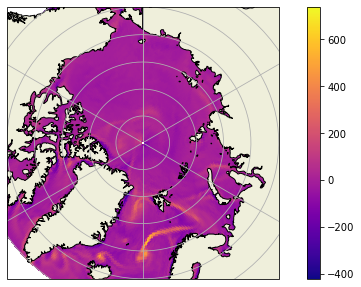

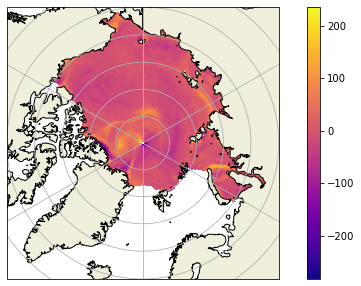

In [115]:
def mask_for_basin(array,basin_mask,fill_with_nans=False):
    x = np.ma.masked_where(basin_mask != 1, array)
    if fill_with_nans: x = np.ma.filled(x,np.nan)
    return(x)

cartoplot(ERA5_lon_grid,ERA5_lat_grid,vort[0])

cartoplot(ERA5_lon_grid,ERA5_lat_grid,mask_for_basin(vort[0],ERA_basin_binary,fill_with_nans=1))

In [116]:
data_dir = '/home/robbie/Dropbox/beaufort_sea/vorticity_files/'


for year in tqdm.trange(1992,2022):
    
    times_daily = {}
    mean_vort_daily = {}
    
    monthrange = range(1,13) if year != 2021 else range(1,3)
    
    for month in monthrange:
        
        with Dataset(f'{data_dir}{year}{str(month).zfill(2)}.nc') as vort_data:
              
            # Get a month worth of vorticity fields
            
            vort = np.array(vort_data['vort_3hr'][:])
            
            # Mask the vorticity field for the basin
            
            # This involves applying a 3D mask to the 3D vort array, in ERA5 coords
            
            vort = mask_for_basin(vort,mon_ERA5_bb[:vort.shape[0]])
            
            # Make a 3D array of latitude weightings

            m_weights = mon_weight[:vort.shape[0]]
            
            # The top row of vorticity data is nans because you can't calculate dy at the top of the world
            
            # This means you have to take the average on everything below the top row
            
            vort_mean = np.ma.average(vort[:,1:],
                                    weights=m_weights[:,1:],
                                    axis=(1,2))
            
            t = np.array(vort_data['hrs_since_1900'][:])
            
            # Calculate Daily Vorticities
            
#             vort_mean = np.mean(np.split(vort_mean, 8),axis=0)

#             t = np.mean(np.split(t,8),axis=0)

            
            times_daily[month] = t
            mean_vort_daily[month] = vort_mean

            
    mean_vort_dict = {'mean_vort':mean_vort_daily,
                     'times':times_daily}
    
    pickle.dump(mean_vort_dict, open(f'{data_dir}{year}_mean_vort.p','wb'))
    


100%|██████████| 30/30 [15:59<00:00, 31.99s/it]


# Get exceptional Feb data

In [117]:
import datetime

(120,)
Mean vorticity in basin: -0.6311234792073568
-3.6056156
63
2021-02-08 21:00:00
2021-02-15 21:00:00


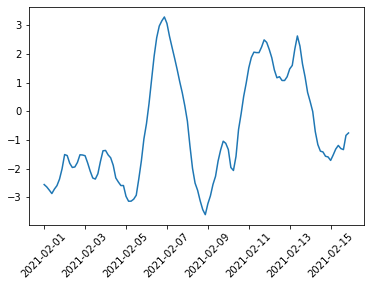

In [154]:
year = 2021

month = 2

vort_data = pickle.load(open(f'{data_dir}{year}_mean_vort.p','rb'))

times_month = vort_data['times'][month]
vorts_month = vort_data['mean_vort'][month]

t0 = datetime.datetime(1900,1,1)

real_times = [t0 + datetime.timedelta(hours=int(s)) for s in vort_data['times'][month]]

print(times_month.shape)

max_vort = np.min(vort_data['mean_vort'][month])

mean_vort = np.mean(vort_data['mean_vort'][month])

mean_vort_2021 = mean_vort.copy()

print(f'Mean vorticity in basin: {mean_vort}')

print(max_vort)

ind_max = np.where(vort_data['mean_vort'][month]==max_vort)[0][0]

print(ind_max)

print(real_times[ind_max])

# print(real_times)

plt.plot(real_times,vorts_month)
plt.xticks(rotation=45)

print(real_times[-1])

In [148]:
all_vort = []

month = 2

mean_vorts_list = []

print(f'Mean vorticity for Feb 2021: {mean_vort_2021}')

for year in tqdm.trange(1992,2021):

    vort_data = pickle.load(open(f'{data_dir}{year}_mean_vort.p','rb'))

    mean_vort_m = np.mean(vort_data['mean_vort'][month])
    print(year)
    print(mean_vort_m)
    
    mean_vorts_list.append(mean_vort_m)
    
    if mean_vort_m < mean_vort:
        print(year)
        print(max_vort_m)

100%|██████████| 29/29 [00:00<00:00, 1036.11it/s]

Mean vorticity for Feb 2021: -0.6311234792073568
1992
0.0032314432078394397
1993
0.9823110444205148
1994
-0.6263678414481026
1995
0.0054795656885419574
1996
2.139270914011988
1997
-0.21985289028712682
1998
0.442422662462507
1999
1.0313307217189245
2000
0.26968530128742085
2001
0.9155195781162807
2002
1.2950188773018974
2003
-0.19503435066768102
2004
0.04005206864455651
2005
0.6278164046151298
2006
2.725569588797433
2007
0.6954029628208706
2008
1.28771946347993
2009
0.6031714848109654
2010
0.4724592481340681
2011
1.2592457362583704
2012
0.40412942294416754
2013
-0.1840336663382394
2014
-0.5408095291682652
2015
0.021125963756016324
2016
0.2348455889471646
2017
0.17341620581490652
2018
1.1367529460362025
2019
1.609079224722726
2020
1.928924560546875


100%|██████████| 29/29 [00:00<00:00, 869.51it/s]


1992
-4.512471
1994
-4.918846
1996
-4.6937966
1997
-3.6829245
1998
-3.830173
2000
-4.783695
2003
-4.070669
2004
-5.7936616
2007
-3.6890292
2012
-4.009509
2013
-4.034891
2014
-4.9143896
2015
-6.563868
2016
-4.00538
2018
-5.3757544
2019
-3.8420992


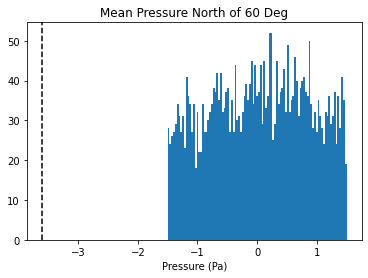

In [133]:
all_vort = []

month = 2

max_vorts_list = []

rec_21 = max_vort

for year in tqdm.trange(1992,2021):

    vort_data = pickle.load(open(f'{data_dir}{year}_mean_vort.p','rb'))

    vort_for_month = list(vort_data['mean_vort'][month])
    
    max_vort_m = np.min(vort_for_month)
    
    max_vorts_list.append(max_vort_m)
    
    if max_vort_m < rec_21:
        print(year)
        print(max_vort_m)
    
    all_vort += vort_for_month
    
    
plt.axvline(x=rec_21,color='k',ls='--')
plt.hist(all_vort,
         bins=np.linspace(-1.5,1.5,100),
        )
plt.title('Mean Pressure North of 60 Deg')
plt.xlabel('Pressure (Pa)')
plt.show()

Text(0.5, 0, 'Year')

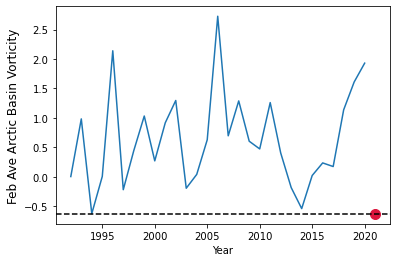

In [151]:
plt.plot(range(1992,2021),mean_vorts_list)
plt.plot(2021,mean_vort_2021,marker='o', color='crimson',markersize=10)
plt.axhline(mean_vort_2021,color='k',ls='--')
plt.ylabel('Feb Ave Arctic Basin Vorticity', fontsize='large')
plt.xlabel('Year')

In [31]:
p = pickle.load(open('/home/robbie/Dropbox/beaufort_sea/vorticity_files/1992_mean_vort.p','rb'))

p.keys()

dict_keys(['mean_slps', 'times'])

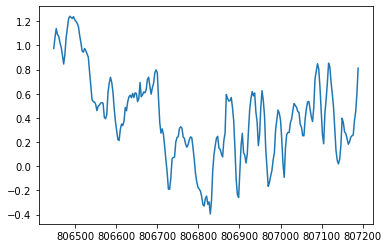

In [32]:
plt.plot(p['times'][1],p['mean_slps'][1])

In [22]:
np.array(ao_feb['year'])

array(['1950', '1951', '1952', '1953', '1954', '1955', '1956', '1957',
       '1958', '1959', '1960', '1961', '1962', '1963', '1964', '1965',
       '1966', '1967', '1968', '1969', '1970', '1971', '1972', '1973',
       '1974', '1975', '1976', '1977', '1978', '1979', '1980', '1981',
       '1982', '1983', '1984', '1985', '1986', '1987', '1988', '1989',
       '1990', '1991', '1992', '1993', '1994', '1995', '1996', '1997',
       '1998', '1999', '2000', '2001', '2002', '2003', '2004', '2005',
       '2006', '2007', '2008', '2009', '2010', '2011', '2012', '2013',
       '2014', '2015', '2016', '2017', '2018', '2019', '2020'],
      dtype=object)

In [44]:
import mask

In [70]:
lon = mask.get('lon')
lat = mask.get('lat')
m = mask.get('mask')
from importlib import reload
import regrid
from regrid import griddata
import xarray as xr

In [50]:
adata = Dataset('/home/robbie/Dropbox/beaufort_sea/iceage_nh_12.5km_20200101_20210204_ql.nc')
alons = np.array(adata['longitude'])
alats = np.array(adata['latitude'])

In [75]:
ds = xr.Dataset( data_vars={'mask':(['x','y'],x)},

                 coords =  {'lon':(['x','y'],alons),
                            'lat':(['x','y'],alats)})

ds.to_netcdf(f'mask720.nc','w')

In [76]:
d = Dataset('mask720.nc')

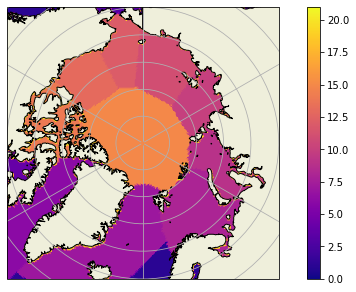

In [79]:
from cartoplot import cartoplot

cartoplot(d['lon'],d['lat'],d['mask'])